In [1]:
import sys
from pathlib import Path
import numpy as np
from scipy.ndimage import center_of_mass
#import warnings
#warnings.filterwarnings("error")
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import numpy as np
from superpose3d import Superpose3D
PIPELINE_ROOT = Path('../src').resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())
print(PIPELINE_ROOT)

from library.registration.brain_structure_manager import BrainStructureManager
from library.registration.algorithm import umeyama

/home/eddyod/programming/preprocessing-pipeline/src


In [150]:
def brain_to_atlas_transform(brain_coord, r, t):
    brain_coord = np.array(brain_coord).reshape(3, 1) # Convert to a column vector
    atlas_coord = r @ brain_coord + t
    return atlas_coord.T[0] # Convert back to a row vector

def calculate_distance(com1, com2):
    return (np.linalg.norm(com1 - com2))

def plot_point_sets_2d(point_sets):
    for y_axis in ['y', 'z']:
        for data, label in point_sets:
            plt.scatter(data[0,:], data['xyz'.index(y_axis),:], label=label, alpha=0.8)
        plt.xlabel('x')
        plt.ylabel(y_axis)
        plt.legend()
        plt.show()
        plt.close()
        
def plot_point_sets_3d(point_sets):
    df = pd.DataFrame()
    for data, label in point_sets:
        df_cur = pd.DataFrame(data.T, columns=['x', 'y', 'z'])
        df_cur['label'] = label
        #df = df.concat(df_cur, ignore_index=True)
        df = pd.concat([df, df_cur], axis= 0)
    
    fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', width=800, height=600)
    fig.update_layout(
    scene={
        'xaxis': {'range': (0, 528)}, 
        'yaxis': {'range': (0, 320)},
        'zaxis': {'range': (0, 456)},
    })
    return fig

def label_left_right(row):
    val = 'Singular'
    if str(row['Structure']).endswith('L'):
        val = 'Left'
    if str(row['Structure']).endswith('R'):
        val = 'Right'
    return val
        

In [3]:
animal = 'Atlas'
brain = BrainStructureManager(animal)
brain.fixed_brain = BrainStructureManager('Allen')

In [ ]:
brainstem_keys = set(brain.allen_structures_keys) - brain.midbrain_keys 

In [4]:
moving_coms = brain.get_coms(annotator_id=1)
allen_coms = brain.fixed_brain.get_coms(annotator_id=1)
common_keys = allen_coms.keys() & moving_coms.keys() &  brain.midbrain_keys
brain_regions = sorted(moving_coms.keys())
allen_points = np.array([allen_coms[s] for s in brain_regions if s in common_keys])
moving_points = np.array([moving_coms[s] for s in brain_regions if s in common_keys])

In [5]:
allen_point_dict = {s:allen_coms[s] for s in brain_regions if s in common_keys}
moving_point_dict = {s:moving_coms[s] for s in brain_regions if s in common_keys}

In [6]:
len(moving_point_dict)

10

In [ ]:
brainstem_keys

In [ ]:
allen_point_dict['SC']

In [ ]:
moving_point_dict['SC']

In [ ]:
distances = []
sortme = {}
for structure in common_keys:
    (x,y,z) = allen_point_dict[structure]
    allen_point = np.array([x,y,z])    
    moving_point = np.array(moving_point_dict[structure])
    #print(atlas_point, allen_point)
    d = calculate_distance(allen_point, moving_point)
    distances.append(d)
    sortme[structure] = d
print(f'n={len(distances)}, min={min(distances)} max={max(distances)}, mean={np.mean(distances)}')
ds = {k: v for k, v in sorted(sortme.items(), key=lambda item: item[1])}
for structure, d in ds.items():
    print(f'{structure} distance from Allen={round(d,2)} micrometers')

In [ ]:
plot_point_sets_3d([
    (moving_points.T/25, 'unaligned moving centers'),
    (allen_points.T/25, 'Allen centers')
])

In [7]:
(RMSD, R1, t1, _) = Superpose3D(allen_points, moving_points, allow_rescale=True)
t1 = t1.reshape(3,1)
print(RMSD)

161.6405431028901


In [8]:
R, t = umeyama(moving_points.T, allen_points.T)

In [9]:
t

array([[ 74.44058764],
       [-56.61758837],
       [-18.93402606]])

In [10]:
reg_points = R @ moving_points.T + t

 That does not preclude starting the new idea but is just to say that somehow we need to get David's attention on what you have done- do a graph
= box plot of the midbrain com distances vs allen (active atlas based)
=box plot of the brainstem vs allen distances (but not using midbrain values to improve the distances)
This should provide an easy visual...


When the tethering is done for the brainstem structures though- he does not want the midbrain metrics to be included ( I don't know though if he means that the alignment is done with midbrain and then the evaluated outputs are only for the brainstem structures...?) your guess is best
So- in any case it was clear that he did not want metrics for midbrain and brainstem structures to be combined.

In [11]:
print('Mean')
print(np.mean(allen_points, axis=0))
print(np.mean(reg_points, axis=1))
print('Min')
print(np.min(allen_points, axis=0))
print(np.min(reg_points, axis=1))
print('Max')
print(np.max(allen_points, axis=0))
print(np.max(reg_points, axis=1))

Mean
[9260.633 3787.901 5690.77 ]
[9260.633 3787.901 5690.77 ]
Min
[8440.38 2325.   3551.05]
[8461.05710224 2256.43218704 3501.82885788]
Max
[10400.    5167.29  7833.27]
[10443.78363247  5007.27342096  7862.93479225]


In [12]:
reg_point_dict = {s:moving_coms[s] for s in brain_regions if s in common_keys}

In [13]:
distances = []
sortme = {}
for structure in common_keys:
    (x,y,z) = allen_point_dict[structure]
    allen_point = np.array([x,y,z])    
    moving_point = np.array(moving_point_dict[structure])
    reg_point = brain_to_atlas_transform(moving_point, R, t)
    d = calculate_distance(allen_point, reg_point)
    distances.append(d)
    #print(f'{structure} COM={reg_point} distance={round(d,2)}')
    sortme[structure] = d

print(f'n={len(distances)}, min={min(distances)} max={max(distances)}, mean={np.mean(distances)}')
ds = {k: v for k, v in sorted(sortme.items(), key=lambda item: item[1])}
for structure, d in ds.items():
    print(f'<tr><td>{structure}</td><td>{round(d,2)}</td></tr>')

n=10, min=101.58424976547154 max=198.57317550049913, mean=157.29589866373152
<tr><td>IC</td><td>101.58</td></tr>
<tr><td>PBG_R</td><td>102.24</td></tr>
<tr><td>SC</td><td>104.04</td></tr>
<tr><td>SNR_R</td><td>165.3</td></tr>
<tr><td>4N_L</td><td>171.43</td></tr>
<tr><td>3N_L</td><td>171.64</td></tr>
<tr><td>3N_R</td><td>177.43</td></tr>
<tr><td>PBG_L</td><td>182.64</td></tr>
<tr><td>4N_R</td><td>198.09</td></tr>
<tr><td>SNR_L</td><td>198.57</td></tr>


In [66]:
allen_points.shape

(10, 3)

In [151]:
df_allen = pd.DataFrame(allen_point_dict.items(), columns=['Structure', 'xyz'])
df_allen['S'] = df_allen.apply (lambda row: label_left_right(row), axis=1)
df_allen[['X', 'Y', 'Z']] = pd.DataFrame(df_allen['xyz'].tolist(), index=df_allen.index)

In [152]:
df_atlas = pd.DataFrame(reg_point_dict.items(), columns=['Structure', 'xyz'])
df_atlas['S'] = df_atlas.apply (lambda row: label_left_right(row), axis=1)
df_atlas[['X', 'Y', 'Z']] = pd.DataFrame(df_atlas['xyz'].tolist(), index=df_atlas.index)

In [134]:
#df_atlas['side'] = np.select([df_atlas.S == 5, str(df_atlas.Structure).endswith('R')],[0, 1], 999)

In [148]:
df_atlas.head()

,Structure,xyz,S,X,Y,Z
0,3N_L,"[9005.63, 3922.59, 5585.43]",L,9005.63,3922.59,5585.43
1,3N_R,"[9025.31, 3944.09, 5866.7]",R,9025.31,3944.09,5866.70
2,4N_L,"[9547.31, 3914.43, 5393.05]",L,9547.31,3914.43,5393.05
3,4N_R,"[9528.97, 3947.09, 5966.02]",R,9528.97,3947.09,5966.02
4,IC,"[10407.76, 2221.39, 5636.55]",S,10407.76,2221.39,5636.55


In [160]:
xmin = 8000
xmax = 13000
ymin = 2000
ymax = 6000
zmin = 0
zmax = 25*456

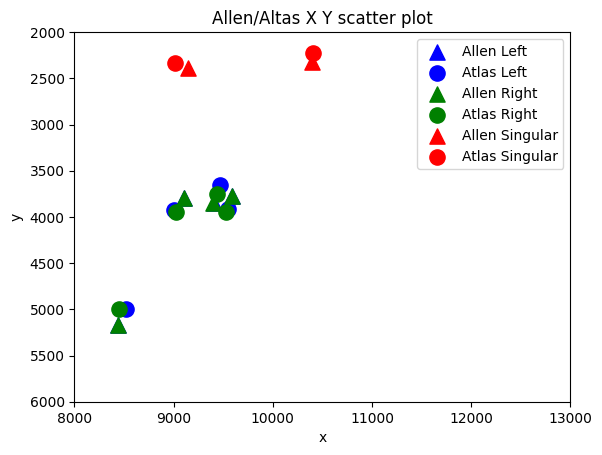

In [166]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_allen[df_allen.S == label]
    atlas_subset = df_atlas[df_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Y, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Y, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Y')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.invert_yaxis()
plt.title('Allen/Altas X Y scatter plot')    
plt.legend()

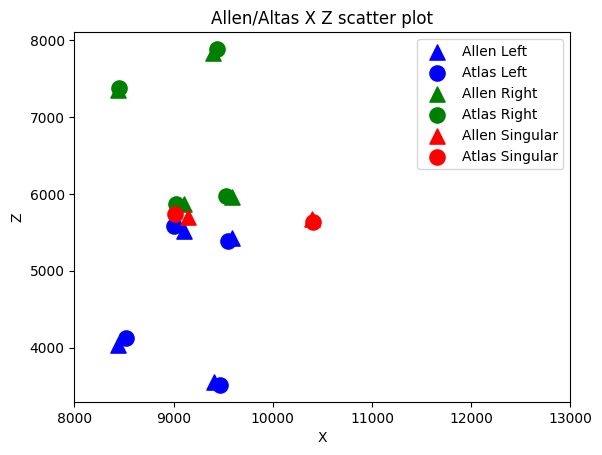

In [169]:
for color, label in zip('bgr', ['Left', 'Right', 'Singular']):
    allen_subset = df_allen[df_allen.S == label]
    atlas_subset = df_atlas[df_atlas.S == label]
    plt.scatter(allen_subset.X, allen_subset.Z, s=120, marker='^', c=color, label=str('Allen ' + label))
    plt.scatter(atlas_subset.X, atlas_subset.Z, s=120, marker='o', c=color, label=str('Atlas ' + label))
    plt.xlabel('X')
    plt.ylabel('Z')
    ax = plt.gca()
    ax.set_xlim([xmin, xmax])
    #ax.set_ylim([ymin, ymax])
    #ax.invert_yaxis()
plt.title('Allen/Altas X Z scatter plot')    
plt.legend()

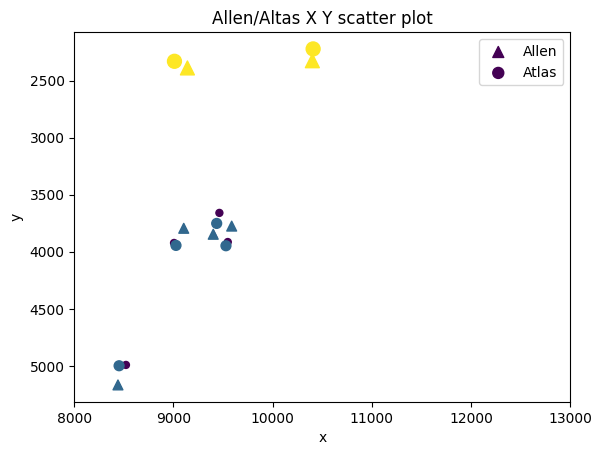

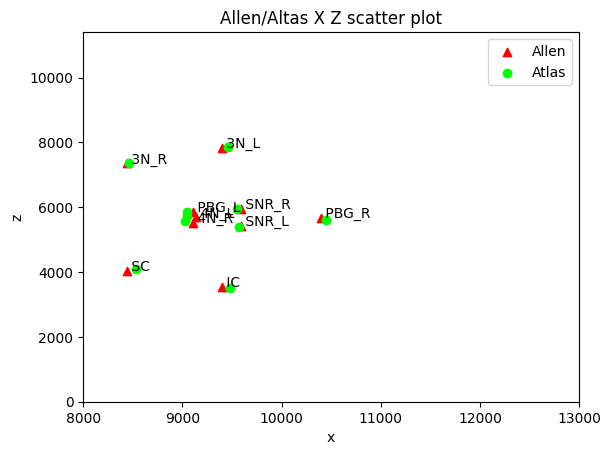

In [142]:

plt.scatter(df_allen.X, df_allen.Y, marker='^', label='Allen', s=df_allen.S, c=df_allen.S)
plt.scatter(df_atlas.X, df_atlas.Y, marker='o', label='Atlas', s=df_atlas.S, c=df_atlas.S)
#for i, txt in enumerate(common_keys):
#    if txt.endswith('R'):
#        plt.annotate(' R', (xA[i], yA[i]))
#    if txt.endswith('L'):
#        plt.annotate(' L', (xA[i], yA[i]))

plt.xlabel('x')
plt.ylabel('y')
ax = plt.gca()
ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
ax.invert_yaxis()
plt.title('Allen/Altas X Y scatter plot')
plt.legend()
plt.show()
plt.close()

plt.scatter(xA, zA, marker='^', c='#FF0000', label='Allen')
plt.scatter(xm, zm, marker='o', c='#00FF00', label='Atlas')
for i, txt in enumerate(common_keys):
    plt.annotate(f' {txt}', (xA[i], zA[i]))
plt.xlabel('x')
plt.ylabel('z')
ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([zmin, zmax])
#ax.invert_yaxis()
plt.title('Allen/Altas X Z scatter plot')
plt.legend()
plt.show()
plt.close()

In [ ]:
reg_points.shape

In [ ]:
plot_point_sets_2d([
    (allen_points, 'Allen centers'),
    (reg_points.T, 'Aligned atlas centers')
])

In [ ]:
plot_point_sets_3d([
    (reg_points/25, 'registered moving centers'),
    (allen_points.T/25, 'Allen centers')    
])